In [ ]:
# !unzip /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/Summaries.zip -d /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/

In [ ]:
# !unzip /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/News\ Articles.zip -d /content/drive/MyDrive/Arrowhead\ Take\ Home\ Assignment/

# Fine-tuning Large Language Models for Text Summarization of BBC News Articles

## Installing / Importing Libraries

Install (run only if not already installed in environment)

In [ ]:
!pip install transformers==4.28.0
!pip install rouge_score
!pip install datasets
!pip install evaluate

Import

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import evaluate
import matplotlib.pyplot as plt
import torch
from statistics import mean, median
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [5]:
# Chooses between GPU and CPU based on availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Organizing Data
- Traversing file directory, combining into a single CSV
- Run this section only if processed CSV is unavailable



In [3]:
# Change based on dataset location
DATA_DIR = '/content/drive/MyDrive/Arrowhead Assignment'

articles_dir = DATA_DIR + '/News Articles'
summaries_dir = DATA_DIR + '/Summaries'

In [4]:
# Initializing Pandas dataframe to store all news articles and summaries
dataset = pd.DataFrame(columns = ['category', 'article', 'summary'])

In [5]:
# Traversing all directories to extract articles and summaries
for category in os.listdir(articles_dir):
    print(category)
    for file in tqdm(os.listdir(articles_dir + '/' + category)):
        # print (os.path.join(articles_dir, category, file))
        na = open(os.path.join(articles_dir, category, file), "r")
        sum = open(os.path.join(summaries_dir, category, file), "r")

        try:
            na, sum = na.read() , sum.read()
        except:
            print('category ' + category + ', file ' + file + ' has utf-8 encoding issue')
            continue
        row = pd.DataFrame

        new_row = pd.DataFrame({'category': category, 'article':na, 'summary':sum}, index=[0])
        dataset = pd.concat([new_row,dataset.loc[:]]).reset_index(drop=True)




entertainment


100%|██████████| 386/386 [01:31<00:00,  4.22it/s]


politics


100%|██████████| 417/417 [01:35<00:00,  4.39it/s]


sport


  4%|▎         | 19/511 [00:07<02:00,  4.09it/s]

category sport, file 199.txt has utf-8 encoding issue


100%|██████████| 511/511 [01:53<00:00,  4.51it/s]


business


100%|██████████| 510/510 [01:56<00:00,  4.37it/s]


tech


100%|██████████| 401/401 [01:28<00:00,  4.52it/s]


In [6]:
# shuffling the final pandas dataframe
dataset = dataset.sample(frac=1, random_state=42).reset_index()

In [7]:
# saving as CSV for future use
dataset.to_csv('/content/drive/MyDrive/Arrowhead Assignment/dataset.csv')

## Analyzing News Articles and Summaries
- Plotting histograms and calculating averages for News Articles and Summaries length
- This would help decide the max size of embedding for input and output

In [6]:
model_name = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/Arrowhead Assignment/dataset.csv', index_col=0)

In [8]:
# Converting pandas df to huggingface dataset
dataset = Dataset.from_pandas(dataset)
# 25% for testing
dataset = dataset.train_test_split(test_size=0.25, shuffle=False)

In [10]:
articles_len_list = [len(tokenizer.encode(article)) for article in dataset['train']['article']]
summaries_len_list = [len(tokenizer.encode(summary)) for summary in dataset['train']['summary']]

Token indices sequence length is longer than the specified maximum sequence length for this model (1046 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
min_a, max_a, av_a = min(articles_len_list), max(articles_len_list), mean(articles_len_list)
min_s, max_s, av_s = min(summaries_len_list), max(summaries_len_list), mean(summaries_len_list)

In [12]:
print('Minimum Article Length:', min_a, '\tMaximum Article Length:', max_a, '\tAverage Article Length:', av_a)
print('Minimum Summary Length:', min_s, '\tMaximum Summary Length:', max_s, '\tAverage Summary Length:', av_s)

Minimum Article Length: 168 	Maximum Article Length: 5337 	Average Article Length: 487.79976019184653
Minimum Summary Length: 57 	Maximum Summary Length: 2535 	Average Summary Length: 212.98860911270984


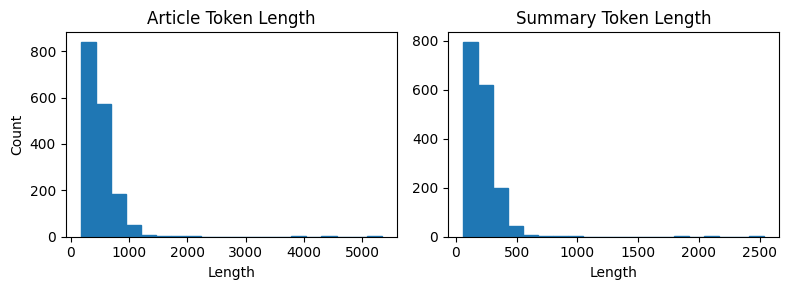

In [13]:
# Plotting histogram of number of tokens for articles and summaries to estimate max tokenization size
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey='col' )
axes[0].hist(articles_len_list, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summaries_len_list, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [14]:
MAX_LEN_ARTICLE = 1024
MAX_LEN_SUMMARY = 512

## Model 1: BART Large CNN by Facebook
- [Huggingface Model Card](https://huggingface.co/facebook/bart-large-cnn)
- Pretrained on English language, fine-tuned on the CNN DailyMail dataset.
- Based on the paper [BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Lewis et al.](https://arxiv.org/abs/1910.13461).
- Both the pretraining and the sequence to sequence nature of the model make it suitable for this task.
- The available training data makes this an ***Extractive Text Summarization*** Task.

### Establishing basline results on Summarization
- Using the test split of the dataset (25%)
- No finetuning on BBC data to establish baseline
- Metrics: Rouge1, Rouge2, RougeL, RougeLSum

In [15]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(DEVICE)

In [16]:
def generate_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]

In [34]:
def eval(dataset, metric, model, tokenizer, batch_size=4, device=DEVICE):

    article_batches = list(generate_batches(dataset['article'], batch_size))
    summary_batches = list(generate_batches(dataset['summary'], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, summary_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=MAX_LEN_ARTICLE,  truncation=True, padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=MAX_LEN_SUMMARY)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]      
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch) 
        # metric2.add_batch(predictions=decoded_summaries, references=target_batch) 
    
    return metric.compute()
 

In [35]:
rouge = evaluate.load('rouge')
# bleu = evaluate.load('bleu')

In [36]:
# torch.cuda.empty_cache()

In [38]:
score = eval(dataset['test'], rouge, model, tokenizer)

100%|██████████| 139/139 [04:32<00:00,  1.96s/it]


In [39]:
score

{'rouge1': 0.34356778472649074,
 'rouge2': 0.23801722715726345,
 'rougeL': 0.25767273840769056,
 'rougeLsum': 0.25749925346920455}

In [40]:
results = pd.DataFrame(score, index = ['bart_baseline'])

In [41]:
results

,rouge1,rouge2,rougeL,rougeLsum
bart_baseline,0.343568,0.238017,0.257673,0.257499


In [42]:
results.to_csv('/content/drive/MyDrive/Arrowhead Assignment/results.csv')

### Finetuning on Train Set
- Features extraction similar to evaluation
- Train for 1 and 4 epochs, save weights and checkpoints
- Using saved weights for evaluation on test set
- Small batch size due to limited compute
- Improved results (ROUGE) over baseline by about minimum 100% (double)

In [43]:
# Compute encodings from text input
def extract_features(batch):

    input_encodings = tokenizer(list(batch['article']) , max_length = int(MAX_LEN_ARTICLE), padding="max_length", return_tensors="pt", truncation = True)
    # with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(list(batch['summary']), max_length = int(MAX_LEN_SUMMARY), padding="max_length", return_tensors="pt", truncation = True)
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [44]:
# To form batches
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [45]:
dataset = dataset.map(extract_features, batched = True)

Map:   0%|          | 0/1668 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    #CHECK WEIGHTS FILE BEFORE RUNNING
    output_dir="/content/drive/MyDrive/Arrowhead Assignment/BART_4_ep",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=3,
    #EPOCHS
    num_train_epochs=3,
    predict_with_generate=True,
    #BATCH SIZE
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.050700,0.071926


In [ ]:
# Save model to Drive
# CHECK PATH BEFORE RUNNING
torch.save(model.state_dict(), "/content/drive/MyDrive/Arrowhead Assignment/BART_4_ep.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Load model for inference
# CHECK PATH BEFORE RUNNING
model.load_state_dict(torch.load("/content/drive/MyDrive/Arrowhead Assignment/BART_4_ep.pth"))

In [ ]:
score = eval(dataset['test'], rouge, model, tokenizer)

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Arrowhead Assignment/results.csv', index_col=0)

In [ ]:
curr_results = pd.DataFrame(score, index = ['bart_finetuned_4_ep'])

In [ ]:
curr_results

In [ ]:
frames = [results, curr_results]
results = pd.concat(frames)

In [ ]:
results

In [ ]:
results.to_csv('/content/drive/MyDrive/Arrowhead Assignment/results.csv')

### Inference
- This section has code to generate a summary given an article
- Input could be any instance of the test data (the model has been trained only on train data) or any other external data similar to the BBC dataset

In [72]:
# Make sure the correct model is loaded
# model.load_state_dict()
generations_args = {'length_penalty': 0.8, 'num_beams': 8, 'max_length': MAX_LEN_SUMMARY}

In [73]:
def generate_summary(article, generations_args, model, device = DEVICE):
    input = tokenizer(article, max_length=MAX_LEN_ARTICLE,  truncation=True, padding="max_length", return_tensors="pt")
    summary = model.generate(input_ids=input["input_ids"].to(device), attention_mask=input["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=MAX_LEN_SUMMARY)
    # summary = tokenizer.decode(summary)      
    decoded_summary = tokenizer.decode(summary[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print(decoded_summary)

In [80]:
dataset['test'][101]['article']

'Liberian economy starts to grow\n\nThe Liberian economy started to grow in 2004, but "sustained and deep reform efforts" are needed to ensure long term growth, the International Monetary Fund (IMF) has said.\n\nAn IMF mission made the comments in a report published following 10 days of talks with the transition government. The IMF said that, according to data provided by the Liberians, the country\'s GDP rose by 2% in 2004, after a 31% decline in 2003. Liberia is recovering from a 14-year civil war that came to an end in 2003. The power-sharing National Transition Government of Liberia will remain in place until elections on 11 October, the first presidential and parliamentary ballots since the conflict ended.\n\nThe IMF said Liberia\'s economy started to grow last year thanks to a "continued strong recovery in rubber production, domestic manufacturing and local services including post-conflict reconstruction". The IMF however remains cautious about what it sees as a lack of transpare

In [81]:
generate_summary(dataset['test'][101]['article'], generations_args, model)

"The IMF team stands ready to assist the (Liberian) authorities in strengthening the areas mentioned," said the report.The IMF said Liberia's economy started to grow last year thanks to a "continued strong recovery in rubber production, domestic manufacturing and local services including post-conflict reconstruction".The IMF also said it was crucial that the Central Bank of Liberia be strengthened, the national budget be effectively managed and a sound economic basis built to allow the country's large external debt to be addressed.These matters are now being investigated by the Liberian authorities and the IMF has called for their findings to be made public.


In [82]:
dataset['test'][101]['summary']

'"The IMF team stands ready to assist the (Liberian) authorities in strengthening the areas mentioned," said the report.These matters are now being investigated by the Liberian authorities and the IMF has called for their findings to be made public.The Liberian economy started to grow in 2004, but "sustained and deep reform efforts" are needed to ensure long term growth, the International Monetary Fund (IMF) has said.An IMF mission made the comments in a report published following 10 days of talks with the transition government.The IMF said that, according to data provided by the Liberians, the country\'s GDP rose by 2% in 2004, after a 31% decline in 2003.'